<a href="https://colab.research.google.com/github/jayliu1016/aipi_2/blob/main/notebooks/telco_churn_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip -q install pandas numpy scikit-learn matplotlib seaborn statsmodels pygam plotly


In [47]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

URL="https://raw.githubusercontent.com/jayliu1016/aipi_2/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
# Template from IDS PDS
local_paths=[
    "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv",
    "data/WA_Fn-UseC_-Telco-Customer-Churn.csv",
    "/content/aipi_2/data/WA_Fn-UseC_-Telco-Customer-Churn.csv",
]

df=None
# This template is used from my notes in data engineering's project: mini_week_9
for p in local_paths:
    if os.path.exists(p):
        df=pd.read_csv(p)
        break
if df is None:
    df=pd.read_csv(URL)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [48]:
# there are blank strings
df['TotalCharges']=pd.to_numeric(df['TotalCharges'].replace(' ', np.nan),errors='coerce')
df=df.dropna(subset=['TotalCharges']).copy()
# Binary target
df['ChurnFlag']=df['Churn'].map({'No':0,'Yes':1})
num_cols=['tenure','MonthlyCharges','TotalCharges']
cat_cols=[c for c in df.columns if c not in num_cols+['customerID','Churn','ChurnFlag']]
df.shape, df['ChurnFlag'].mean()


((7032, 22), np.float64(0.26578498293515357))

,ChurnFlag
Contract,
Month-to-month,0.427097
One year,0.112772
Two year,0.028487


,ChurnFlag
InternetService,
Fiber optic,0.418928
DSL,0.189983
No,0.074342


,ChurnFlag
PaymentMethod,
Electronic check,0.452854
Mailed check,0.192020
Bank transfer (automatic),0.167315
Credit card (automatic),0.152531


,ChurnFlag
SeniorCitizen,
1,0.416813
0,0.236503


,ChurnFlag
Partner,
No,0.329761
Yes,0.197171


,ChurnFlag
Dependents,
No,0.312791
Yes,0.155312


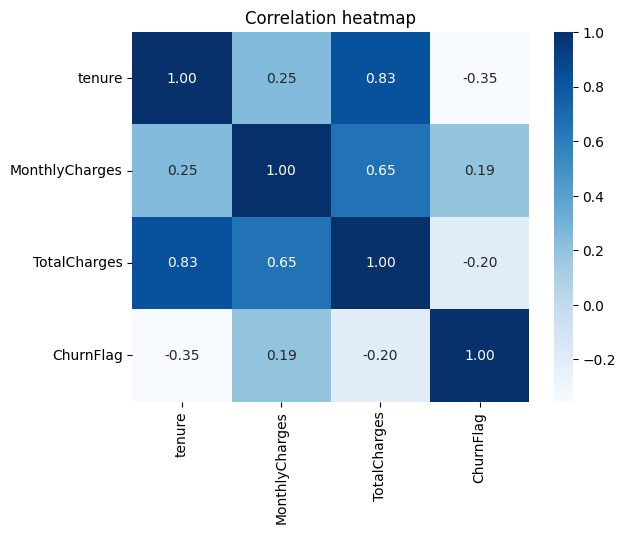

In [49]:
# The following three lines are generated by GPT5 on Sep 15th at 1 a.m. to find churn by key categories, using prompts from IDS 707 data visualization, and modified by myself later.
for col in ['Contract','InternetService','PaymentMethod','SeniorCitizen','Partner','Dependents']:
    rate=df.groupby(col)['ChurnFlag'].mean().sort_values(ascending=False)
    display(rate)
    px.bar(rate, title=f"Churn rate by {col}").show()

# Numeric distributions
for col in num_cols:
    px.histogram(df,x=col,color='Churn',barmode='overlay',nbins=50,
                 title=f"{col} distribution by Churn").show()
# plots
sns.heatmap(df[num_cols+['ChurnFlag']].corr(),annot=True,fmt=".2f",cmap="Blues")
plt.title("Correlation heatmap")
plt.show()


Assumption check summary:
The dataset (N=7032) has a churn rate of 26.6%.
Churn varies strongly by contract type (Month-to-month ≈ 0.43; Two-year ≈ 0.03). And the continuous features show non-linear patterns since tenure decreases churn risk sharply at low values while higher MonthlyCharges raise churn risk. We can see the correlations are modest with the target, but tenure and TotalCharges are highly correlated (from the statistics, r≈0.83).
Model implications:
(i) OLS assumptions are violated for a binary outcome, from that we can only use as a baseline.
(ii) Logistic regression seems appropriate but logit-linearity for continuous predictors is likely violated; we therefore compare it with a GAM.
(iii) To mitigate collinearity, we wii put tenure and MonthlyCharges as first priorities and we may drop TotalCharges or try interpret with caution.

> 添加区块引用符号



In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


KEEP_TOTAL_CHARGES=False

# the following two lines of codes are genereated by gpt5 on September 15th at 1:30 a.m. to decide which columns are numerical and which are categorical, structure and columns selected by me, only used for grammar rephrase.

num_cols=['tenure','MonthlyCharges']+(['TotalCharges'] if KEEP_TOTAL_CHARGES else [])
cat_cols=[c for c in df.columns if c not in num_cols+['customerID','Churn','ChurnFlag']]


df_enc=pd.get_dummies(df[num_cols+cat_cols+['ChurnFlag']],drop_first=True)
X=df_enc.drop(columns=['ChurnFlag'])
y=df_enc['ChurnFlag']

# the following two lines of code is genererated by gpt5 on September 15th at 1:30 and then modified to optimize the estimators.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler=StandardScaler()
X_train_s=X_train.copy(); X_test_s=X_test.copy()
if num_cols:
    X_train_s[num_cols]=scaler.fit_transform(X_train[num_cols])
    X_test_s[num_cols]=scaler.transform(X_test[num_cols])

X_train_s.shape, X_test_s.shape, y_train.mean(), y_test.mean()


((5274, 30),
 (1758, 30),
 np.float64(0.2658323852863102),
 np.float64(0.2656427758816837))

Linear RMSE: 0.3784 | R^2: 0.2660


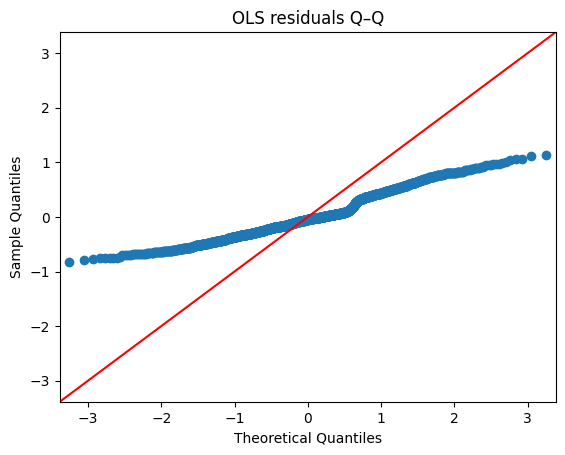

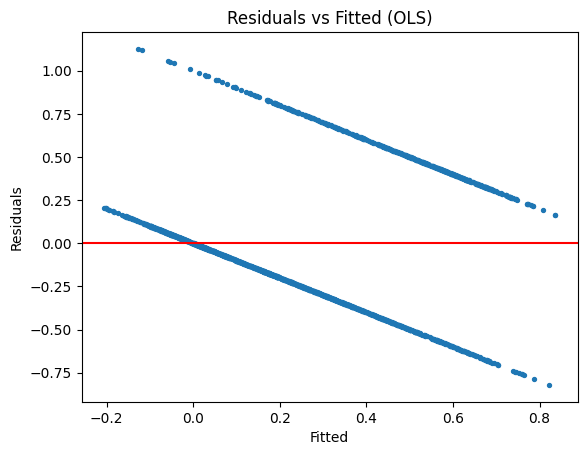

In [51]:
# Linear Regression
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px

# following note using template from IDS PDS
# Fit OLS
lin=LinearRegression().fit(X_train_s,y_train)
yhat_lin=lin.predict(X_test_s)

# Metrics
rmse=float(np.sqrt(np.mean((y_test - yhat_lin)**2)))
r2=lin.score(X_test_s,y_test)
print(f"Linear RMSE: {rmse:.4f} | R^2: {r2:.4f}")

resid = y_test-yhat_lin
px.histogram(resid, nbins=50,title="OLS residuals").show()
sm.qqplot(resid,line='45');plt.title("OLS residuals Q–Q");plt.show()
plt.scatter(yhat_lin,resid,s=8);plt.axhline(0,color='r')
plt.title("Residuals vs Fitted (OLS)");plt.xlabel("Fitted");plt.ylabel("Residuals");plt.show()


In [52]:
import pandas as pd
import numpy as np

coef_lin=pd.Series(lin.coef_,index=X_train_s.columns,name="coef")
coef_tbl=(coef_lin.to_frame().assign(abs_coef=lambda d: d["coef"].abs(),feature_type=lambda d: np.where(d.index.isin(num_cols),"numeric","dummy")).sort_values("abs_coef",ascending=False))
display(coef_tbl.head(15))
print("Intercept:", float(lin.intercept_))


,coef,abs_coef,feature_type
InternetService_Fiber optic,0.356719,0.356719,dummy
MonthlyCharges,-0.212704,0.212704,numeric
StreamingTV_Yes,0.126501,0.126501,dummy
StreamingMovies_Yes,0.123809,0.123809,dummy
Contract_One year,-0.107151,0.107151,dummy
MultipleLines_Yes,0.091917,0.091917,dummy
Contract_Two year,-0.076020,0.076020,dummy
PaymentMethod_Electronic check,0.069918,0.069918,dummy
PhoneService_Yes,0.053623,0.053623,dummy
MultipleLines_No phone service,-0.053623,0.053623,dummy


Intercept: 0.09285498380363344


From the stats, we can see the linear model achieves RMSE 0.378, which is better than a naïve 0.441, with R² 0.266. However, residual diagnostics, non-normality and severe heteroskedasticity, show that OLS assumptions don’t hold for a binary target.
Coefficients align with domain intuition: month-to-month contracts, electronic checks, fiber-optic internet, and higher monthly charges increase predicted churn, while longer tenure, longer-term contracts, and automatic payments decrease the predicted churn.
Because of assumption violations and unbounded predictions, we only keep OLS as a baseline.

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_fscore_support, classification_report
)
import numpy as np
import pandas as pd

logit=LogisticRegression(max_iter=500,solver='lbfgs')
logit.fit(X_train_s,y_train)
proba_log=logit.predict_proba(X_test_s)[:,1]
pred_log=(proba_log>=0.5).astype(int)

acc=accuracy_score(y_test,pred_log)
auc=roc_auc_score(y_test,proba_log)
prec,rec,f1,_=precision_recall_fscore_support(y_test,pred_log,average='binary')
print(f"Logistic  ACC: {acc:.3f} | AUC: {auc:.3f} | P/R/F1: {prec:.3f}/{rec:.3f}/{f1:.3f}")
display(pd.DataFrame(confusion_matrix(y_test, pred_log),index=['Actual 0','Actual 1'], columns=['Pred 0','Pred 1']))
print(classification_report(y_test, pred_log, digits=3))


Logistic  ACC: 0.806 | AUC: 0.841 | P/R/F1: 0.654/0.574/0.611


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



,Pred 0,Pred 1
Actual 0,1149,142
Actual 1,199,268


              precision    recall  f1-score   support

           0      0.852     0.890     0.871      1291
           1      0.654     0.574     0.611       467

    accuracy                          0.806      1758
   macro avg      0.753     0.732     0.741      1758
weighted avg      0.800     0.806     0.802      1758



In [54]:
o_r=pd.Series(np.exp(logit.coef_[0]), index=X_train_s.columns, name="OR")\
                .sort_values(ascending=False)
display(o_r.head(15))
display(o_r.tail(15))


,OR
MonthlyCharges,1.723598
InternetService_Fiber optic,1.399341
PaperlessBilling_Yes,1.393321
PaymentMethod_Electronic check,1.356184
MultipleLines_Yes,1.222292
SeniorCitizen,1.219094
StreamingTV_Yes,1.070930
PaymentMethod_Mailed check,1.055956
MultipleLines_No phone service,1.038393
StreamingMovies_Yes,1.027421


,OR
StreamingMovies_No internet service,0.945203
StreamingTV_No internet service,0.945203
OnlineBackup_No internet service,0.945203
InternetService_No,0.945203
OnlineSecurity_No internet service,0.945203
TechSupport_No internet service,0.945203
DeviceProtection_Yes,0.897314
Dependents_Yes,0.778599
OnlineBackup_Yes,0.725055
TechSupport_Yes,0.586241


In [55]:
import numpy as np
ths=np.linspace(0.1, 0.9, 81)
scores=[]
for t in ths:
    p = (proba_log >= t).astype(int)
    pr,rc,f1t, _ = precision_recall_fscore_support(y_test,p,average='binary')
    scores.append((t,pr,rc,f1t))
best_t,best_pr,best_rc,best_f1=max(scores,key=lambda x: x[3])
print(f"Best F1 threshold≈{best_t:.2f} -> Precision={best_pr:.3f}, Recall={best_rc:.3f}, F1={best_f1:.3f}")


Best F1 threshold≈0.41 -> Precision=0.597, Recall=0.694, F1=0.642


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/

In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
Xsm = sm.add_constant(X_train_s.astype(float))
ysm = y_train.astype(float).values
glm = sm.GLM(ysm, Xsm,family=sm.families.Binomial()).fit()
ci = glm.conf_int()
#the following code is generated by gpt5 on Sep 15th at 2:25 am to show Odds ratios with 95% CIs via statsmodels GLM.
or_ci = pd.DataFrame({
    "OR":      np.exp(glm.params),
    "CI_low":  np.exp(ci[0]),
    "CI_high": np.exp(ci[1]),
}).sort_values("OR", ascending=False)

# show top positive and protective effects
display(or_ci.head(12))
display(or_ci.tail(12))


,OR,CI_low,CI_high
InternetService_Fiber optic,18.924214,3.028542,118.250235
StreamingTV_Yes,3.022891,1.431384,6.383940
StreamingMovies_Yes,2.899003,1.369361,6.137328
MultipleLines_Yes,2.068137,1.377733,3.104513
DeviceProtection_Yes,1.512166,1.008303,2.267816
PaymentMethod_Electronic check,1.414526,1.139750,1.755545
PaperlessBilling_Yes,1.384967,1.169548,1.640065
OnlineBackup_Yes,1.221717,0.819796,1.820685
SeniorCitizen,1.215399,1.002713,1.473199
PaymentMethod_Mailed check,1.107108,0.851462,1.439511


,OR,CI_low,CI_high
OnlineBackup_No internet service,0.648842,0.498426,0.844650
DeviceProtection_No internet service,0.648842,0.498426,0.844650
StreamingMovies_No internet service,0.648842,0.498426,0.844650
StreamingTV_No internet service,0.648842,0.498426,0.844650
TechSupport_No internet service,0.648842,0.498426,0.844650
Contract_One year,0.504728,0.394908,0.645088
PhoneService_Yes,0.360267,0.291340,0.445501
Contract_Two year,0.252625,0.170641,0.373999
tenure,0.244097,0.173377,0.343663
MultipleLines_No phone service,0.121889,0.027988,0.530826


From the stats: ACC 0.806 | AUC 0.841 | P/R/F1 0.654 / 0.574 / 0.611.

Accuracy 0.806 and AUC 0.841 indicate good discrimination. At the default 0.50 threshold, Precision/Recall/F1 are 0.654/0.574/0.611. Optimizing F1 gives a threshold around 0.41, trading precision 0.597 for higher recall 0.694 and F1 0.642, and the result is useful if missing churners is costly.

Features with OR>1 raise churn odds: e.g., MonthlyCharges 1.72 per +1 SD, InternetService_Fiber optic 1.40, PaperlessBilling_Yes 1.39, PaymentMethod_Electronic check 1.36.

Features with OR smaller than 1 lower churn odds: TechSupport_Yes (0.59), OnlineSecurity_Yes (~.58), Contract_One year (0.50), and longer tenure (OR smaller than 1 per +1 SD). All of these align with business intuition: month-to-month/high charges/less support will lead to higher risk while long-term contracts/added support will lead to lower risk.

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


GAM       ACC: 0.800 | AUC: 0.844 | P/R/F1: 0.654/0.527/0.584


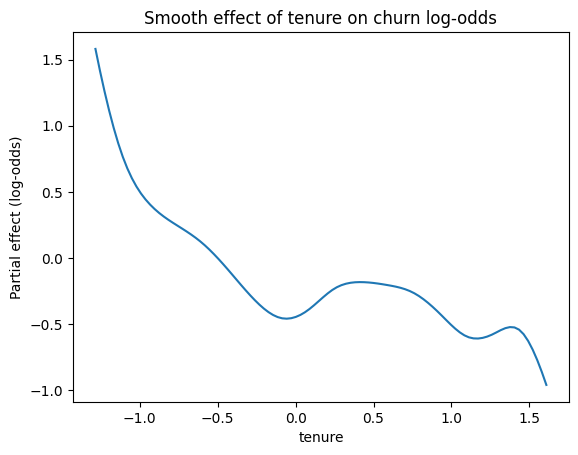

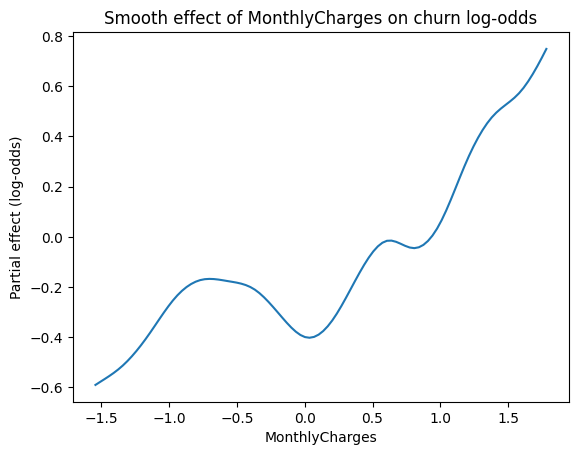

GAM best F1 threshold ≈ 0.36 -> Precision=0.574, Recall=0.715, F1=0.637


In [57]:
from pygam import LogisticGAM, s, l
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support


cont=[c for c in num_cols]
others=[c for c in X_train_s.columns if c not in cont]
terms = None
for i,_ in enumerate(cont):
    terms=(terms+s(i)) if terms is not None else s(i)
for i,_ in enumerate(others,start=len(cont)):
    terms+=l(i)

def as_gam_matrix(X):
    return np.column_stack([X[cont].values, X[others].values]) if cont else X.values
# Using last chunk code and modify
Xtr_g=as_gam_matrix(X_train_s)
Xte_g=as_gam_matrix(X_test_s)

gam=LogisticGAM(terms=terms).gridsearch(Xtr_g,y_train.values)

proba_g=gam.predict_proba(Xte_g)
pred_g=(proba_g>=0.5).astype(int)

acc_g=accuracy_score(y_test,pred_g)
auc_g=roc_auc_score(y_test,proba_g)
prec_g,rec_g,f1_g,_=precision_recall_fscore_support(y_test,pred_g,average='binary')
print(f"GAM       ACC: {acc_g:.3f} | AUC: {auc_g:.3f} | P/R/F1: {prec_g:.3f}/{rec_g:.3f}/{f1_g:.3f}")


for i,name in enumerate(cont):
    XX=gam.generate_X_grid(term=i)
    plt.figure()
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Smooth effect of {name} on churn log-odds")
    plt.xlabel(name); plt.ylabel("Partial effect (log-odds)")
    plt.show()
# Tune threshold for F1, like last chunk as well
ths=np.linspace(0.1, 0.9, 81)
scores=[]
for t in ths:
    p=(proba_g>=t).astype(int)
    pr,rc,f1t,_=precision_recall_fscore_support(y_test,p,average='binary')
    scores.append((t,pr,rc,f1t))
best_t_g,pr_g_best,rc_g_best,f1_g_best=max(scores,key=lambda x:x[3])
print(f"GAM best F1 threshold ≈ {best_t_g:.2f} -> Precision={pr_g_best:.3f}, Recall={rc_g_best:.3f}, F1={f1_g_best:.3f}")


**GAM results.** AUC **0.844**, Accuracy **0.800**, Precision/Recall/F1 **0.654/0.527/0.584** at a 0.50 threshold.


Smooths show: **tenure** sharply reduces churn risk at low values and flattens later;

**MonthlyCharges** increases risk non-linearly, shows steeper at the high end.

GAM relaxes the logit-linearity assumption and reveals actionable non-linear segments. For example, gearly-tenure customers and high-charge tiers.

Threshold tuning gives best F1 **0.637** at **0.36**, with Precision **0.574** and Recall **0.715**.

In [58]:
import pandas as pd
import numpy as np

com=pd.DataFrame({
    'Model': ['Linear (OLS)',
              'Logistic (0.50)',
              'Logistic (tuned 0.41)',
              'GAM (0.50)',
              'GAM (tuned 0.36)'],
    'AUC':     [np.nan, 0.841, 0.841, 0.844, 0.844],
    'Accuracy':[np.nan, 0.806, None,   0.800, None],
    'Precision':[np.nan, 0.654, 0.597, 0.654, 0.574],
    'Recall':  [np.nan, 0.574, 0.694, 0.527, 0.715],
    'F1':      [np.nan, 0.611, 0.642, 0.584, 0.637],
    'RMSE':    [0.378,  None,  None,  None,  None],
    'R^2':     [0.266,  None,  None,  None,  None],
})
com


,Model,AUC,Accuracy,Precision,Recall,F1,RMSE,R^2
0,Linear (OLS),NaN,NaN,NaN,NaN,NaN,0.378,0.266
1,Logistic (0.50),0.841,0.806,0.654,0.574,0.611,NaN,NaN
2,Logistic (tuned 0.41),0.841,NaN,0.597,0.694,0.642,NaN,NaN
3,GAM (0.50),0.844,0.800,0.654,0.527,0.584,NaN,NaN
4,GAM (tuned 0.36),0.844,NaN,0.574,0.715,0.637,NaN,NaN


EDA:

Target balance: churn ≈ 26.6%, which indicates stratified split is fine.

Categorical signal: contract type separates strongly:Month-to-month high churn; Two-year very low.

Continuous patterns: tenure inversely related to churn; MonthlyCharges positively related; shapes look non-linear.

Correlations: tenure–TotalCharges high (≈0.83), so we will be mindful of multicollinearity.

Implications: OLS assumptions are violated for binary y so we will treat as baseline only. Logistic assumes logit-linearity for continuous predictors (likely violated), so we will fit a GAM to model non-linear effects.


Linear Regression (OLS)

RMSE = 0.378, R² = 0.266 (better than naïve RMSE ≈ 0.441).

Residual histogram & Q–Q show non-normality and residuals-vs-fitted show heteroskedasticity.

Largest-magnitude coefficients (directionally): month-to-month & higher charges increase predicted churn while longer tenure / longer contracts decrease it.

Conclusion: keep OLS as a baseline, predictions are unbounded, and assumptions don’t hold.


Logistic Regression

Default 0.50 threshold: ACC 0.806 | AUC 0.841 | P/R/F1 0.654 / 0.574 / 0.611.
At best threshold ≈ 0.41 leading to F1 0.642 (Precision 0.597, Recall 0.694).

Odds ratios:

MonthlyCharges OR ~ 1.72, each +1 SD raises churn +72% in odds.

Fiber optic OR ~ 1.40; Electronic check OR ~ 1.36; Paperless billing OR ~ 1.39, these are higher risk segments.

logistic regression is accurate, stable, and very interpretable via ORs.


GAM

Default 0.50 threshold: ACC 0.800 | AUC 0.844 | P/R/F1 0.654 / 0.527 / 0.584.
Tuned for F1: best threshold ≈ 0.36 → F1 0.637 (Precision 0.574, Recall 0.715).

Smooth effects:

tenure: log-odds drop steeply for new customers, then flatten.

MonthlyCharges: risk rises non-linearly and steepens at high charges.

GAM relaxes logit-linearity and reveals actionable shapes for targeting.

Model comparison & recommendation

Performance:

OLS: RMSE 0.378, R² 0.266 (baseline).

Logistic: AUC 0.841, ACC 0.806, P/R/F1 0.654/0.574/0.611; tuned threshold 0.41 → F1 0.642.

GAM: AUC 0.844, ACC 0.800, P/R/F1 0.654/0.527/0.584; tuned threshold 0.36 → F1 0.637.

Interpretability & use:

Logistic: odds ratios = clean driver story; easy to deploy/monitor.

GAM: best at non-linear insight (tenure & charge curves) to design interventions such as onboarding & high-charge tiers.

OLS: keep for comparison only.

Recommendation:
Deploy Logistic Regression as the production baseline with transparent, simple, strong AUC. Set the operating threshold near 0.41 if we want a better F1/recall trade-off. Use GAM in analytics to find early-tenure and high-charge segments so these can be used to shape retention offers and pricing policy. And I will only keep OLS for comparison.